In [3]:
import pandas as pd
import json
import numpy as np
from src.data_utils import load_xsum_dict

xsum_test = load_xsum_dict("test")

def read_logs(path):
    iteration_logs = json.load(open(path, "r"))

    data = []
    edits_by_sum_id = {}
    for iteration in iteration_logs:
        result_obj = {
            "iteration": iteration["iteration"],
            "summaries_generated": iteration['summary_generated']
        }
        data.append(result_obj)
    
    return pd.DataFrame(data).set_index("iteration")

def normalize_df(df):
    return df / df.sum()


# dataset = "pegasus"
# dataset = "bart-test-extrinsic-100"
dataset = "bart-full"

bart_full_iteration_stats = normalize_df(read_logs("results/iteration-changes/bart-full-classifier-knnv1.json"))
bart_oracle_100_iteration_stats = normalize_df(read_logs("results/iteration-changes/bart-test-extrinsic-100-oracle.json"))
bart_knn_100_iteration_stats = normalize_df(read_logs("results/iteration-changes/bart-test-extrinsic-100-classifier-knnv1.json"))

print('100-sample oracle')
display(bart_oracle_100_iteration_stats)
print('100-sample knn')
display(bart_knn_100_iteration_stats)
print('full Xsum test (knn)')
display(bart_full_iteration_stats)

experiment_raw_data = {
    'bart-full': bart_full_iteration_stats,
    'bart-oracle-100': bart_oracle_100_iteration_stats,
    'bart-knn-100': bart_knn_100_iteration_stats
}

Using custom data configuration default
Reusing dataset xsum (/Users/daniel/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

100-sample oracle


,summaries_generated
iteration,
0,0.413223
1,0.214876
2,0.148760
3,0.095041
4,0.057851
5,0.049587
6,0.016529
7,0.004132


100-sample knn


,summaries_generated
iteration,
0,0.403226
1,0.209677
2,0.153226
3,0.116935
4,0.052419
5,0.032258
6,0.012097
7,0.004032
8,0.004032


full Xsum test (knn)


,summaries_generated
iteration,
0,0.542504
1,0.177819
2,0.114637
3,0.078116
4,0.051838
5,0.019720
6,0.009190
7,0.003255
8,0.001484


In [4]:
iteration_convergence_across_experiments = []
for experiment_name, raw_stats in experiment_raw_data.items():
    def compute_examples_converged_during_iteration(iteration_stat):
        next_iteration_idx = iteration_stat.name + 1
        try:
            next_iteration_summaries_generated = raw_stats.loc[next_iteration_idx, 'summaries_generated']
        except KeyError:
            next_iteration_summaries_generated = 0

        return iteration_stat['summaries_generated'] - next_iteration_summaries_generated

    examples_converged_across_iterations = []
    for index, iteration_stat in raw_stats.iterrows():
        examples_converged = compute_examples_converged_during_iteration(iteration_stat)
        examples_converged_across_iterations.append(examples_converged)

    examples_converged_across_iterations = pd.Series(examples_converged_across_iterations)
    iteration_convergence_across_experiments.append((experiment_name, examples_converged_across_iterations))

iteration_convergence_across_experiments = dict(iteration_convergence_across_experiments)
iteration_convergence_across_experiments.keys()

dict_keys(['bart-full', 'bart-oracle-100', 'bart-knn-100'])

In [50]:
foo = pd.DataFrame(iteration_convergence_across_experiments['bart-oracle-100'], columns=['examples_converged']).reset_index()
foo['system'] = 'oracle'
foo = foo.rename(columns={'index': 'iteration_index'})
bar = pd.DataFrame(iteration_convergence_across_experiments['bart-knn-100'], columns=['examples_converged']).reset_index()
bar['system'] = 'knn'
bar = bar.rename(columns={'index': 'iteration_index'})

to_plot = pd.concat([foo, bar]).reset_index().drop(columns=['index'])
to_plot

,iteration_index,examples_converged,system
0,0,0.198347,oracle
1,1,0.066116,oracle
2,2,0.053719,oracle
3,3,0.037190,oracle
4,4,0.008264,oracle
5,5,0.033058,oracle
6,6,0.012397,oracle
7,7,0.004132,oracle
8,0,0.193548,knn
9,1,0.056452,knn


Text(0.5, 1.0, 'Convergence over Iterations (N = 100)')

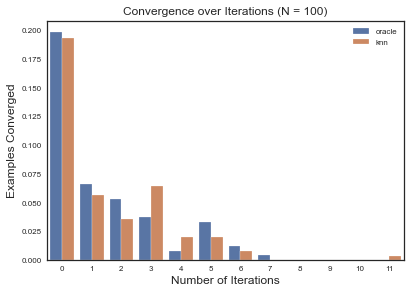

In [60]:
# plt.figure(figsize = (6,2))
plt.figure()
ax = sns.barplot(data=to_plot, x='iteration_index', y='examples_converged', hue='system')
ax.set_xlabel("Number of Iterations", fontsize=12)
ax.set_ylabel('Examples Converged', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('Convergence over Iterations (N = 100)', fontsize=12)

In [64]:
pd.DataFrame(iteration_convergence_across_experiments['bart-full']).reset_index()

,index,0
0,0,0.364685
1,1,0.063182
2,2,0.036521
3,3,0.026278
4,4,0.032118
5,5,0.010530
6,6,0.005935
7,7,0.001771
8,8,0.000718
9,9,0.000287


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Convergence over Iterations (N = 100)')

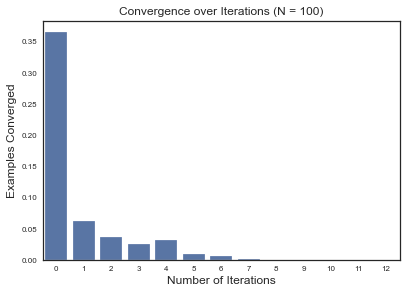

In [80]:
# plt.figure(figsize = (6,2))
plt.figure()
ax = sns.barplot(
    data=pd.DataFrame(iteration_convergence_across_experiments['bart-full']).reset_index(),
    x='index',
    y=0,
    color='#4c72b0'
)
ax.set_xlabel("Number of Iterations", fontsize=12)
ax.set_ylabel('Examples Converged', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('Convergence over Iterations (N = 100)', fontsize=12)

In [81]:
baz = pd.DataFrame(iteration_convergence_across_experiments['bart-full'], columns=['examples_converged']).reset_index()
baz['system'] = 'knn-full'
baz = baz.rename(columns={'index': 'iteration_index'})

to_plot_all = pd.concat([to_plot, baz]).reset_index().drop(columns=['index'])

to_plot_all

,iteration_index,examples_converged,system
0,0,0.198347,oracle
1,1,0.066116,oracle
2,2,0.053719,oracle
3,3,0.037190,oracle
4,4,0.008264,oracle
5,5,0.033058,oracle
6,6,0.012397,oracle
7,7,0.004132,oracle
8,0,0.193548,knn
9,1,0.056452,knn


Text(0.5, 1.0, 'Convergence over Iterations')

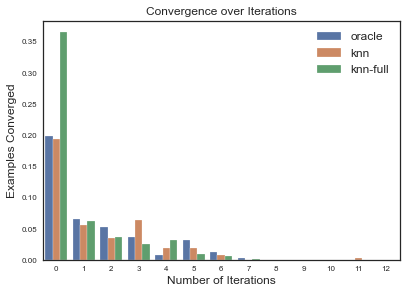

In [85]:
# plt.figure(figsize = (6,2))
plt.figure()
ax = sns.barplot(data=to_plot_all, x='iteration_index', y='examples_converged', hue='system')
ax.set_xlabel("Number of Iterations", fontsize=12)
ax.set_ylabel('Examples Converged', fontsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Convergence over Iterations', fontsize=12)